In [1]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities
import numpy as np
import os
import json
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split


from models import CNN_Encoder, RNN_Decoder, image_features_extract_model

In [2]:
embedding_dim = 1024 # should not be equal units
units = 512
vocab_size = 3000 + 1
embedding_words = 300
CHECKPOINT_FOLDER = "./checkpoint_dis/augmented_w_2gru"
TOKENIZER_FOLDER = './tokenizer/'
MAX_LENGTH = 20

In [3]:
encoder= CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_words, units, vocab_size)

In [4]:
checkpoint_path = CHECKPOINT_FOLDER
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [5]:
ckpt_manager.checkpoints

['./checkpoint_dis/augmented_w_2gru/ckpt-3',
 './checkpoint_dis/augmented_w_2gru/ckpt-4',
 './checkpoint_dis/augmented_w_2gru/ckpt-5',
 './checkpoint_dis/augmented_w_2gru/ckpt-6',
 './checkpoint_dis/augmented_w_2gru/ckpt-7']

### CHOSE CHECKPOINT TO LOAD

In [6]:
## load some checkpoint

n = 1

checkpoint = ckpt_manager.checkpoints[-n]

start_epoch = int(checkpoint.split('-')[-1])
print(f'load from {checkpoint}')
# restoring the latest checkpoint in checkpoint_path
ckpt.restore(checkpoint)

load from ./checkpoint_dis/augmented_w_2gru/ckpt-7


In [7]:
with open(os.path.join(TOKENIZER_FOLDER,'tokenizer_sbpe.json')) as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [8]:
tokenizer.index_word[43]

'▁about'

In [12]:
data.head()

,Unnamed: 0,Unnamed: 0.1,captions,paths,title
0,6,6,<start> how to let a guy know your fingering p...,./disney_img/9.jpg,how to let a guy know your fingering preference
1,37,37,<start> how to distract from your broken eye <...,./disney_img/53.jpg,how to distract from your broken eye
2,38,38,<start> how to find your new butterfly girlfri...,./disney_img/54.jpg,how to find your new butterfly girlfriend.
3,46,46,<start> how to ensure your check box works <end>,./disney_img/65.jpg,how to ensure your check box works
4,49,49,<start> how to have a normal life as arya star...,./disney_img/68.jpg,how to have a normal life (as arya stark)


### GET TEST TRAIN SPLIT

In [21]:
data = pd.read_csv('val.csv')
disney_captions_val = data.title.to_list()
disney_images_val = data.paths.to_list()

In [22]:
data = pd.read_csv('train.csv')
disney_captions_train = data.title.to_list()
disney_images_train = data.paths.to_list()

In [18]:
def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img #, image_path


def evaluate_temp(image, t,max_length,  argmax = 2):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image), 0)
    img_tensor_val_one, img_tensor_val_two = image_features_extract_model(temp_input)
    img_tensor_val_one = tf.reshape(img_tensor_val_one, (img_tensor_val_one.shape[0], -1, img_tensor_val_one.shape[3]))
    img_tensor_val_two = tf.reshape(img_tensor_val_two, (img_tensor_val_two.shape[0], -1, img_tensor_val_two.shape[3]))
    features_one, features_two = encoder(img_tensor_val_one,img_tensor_val_two)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    score = 0

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
        
        ### Slighlty randomize prediction - can be changed to Beam Search ###
        
        # SET TO 2 - 4 IF ARGMAX POlICY REQUIRED #
        if i%argmax==0:
            #predictions = tf.nn.softmax(predictions/t)
            predicted_id = tf.random.categorical(predictions/t, 1)[0][0].numpy()
        else:
            predicted_id = np.argmax(predictions[0].numpy())
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, score/len(result)

        dec_input = tf.expand_dims([predicted_id], 0)
        score+=predictions[0][predicted_id].numpy()
    
    return result, score/len(result)

In [107]:
img_name_val = disney_images_train
captions = disney_captions_train

img_name_path = [p.replace('features','disney_old/disney_img') for  p  in img_name_val]

Real Caption: how to turn your throat into a gas pedal
0.5,  how to take a snroat as a soapal opinist for their soapon, score 22.05831894874573
0.7,  how to plan your throesse <end>, score 24.57529458999634
0.9,  how to take a race schedue for cheap <end>, score 19.542117834091187
1,  how to speak new people <end>, score 20.515565872192383
1.2,  how to remove your person whitzels <end>, score 23.025226419622246
1.5,  how to alien your time to be a friend <end>, score 20.426216212185945


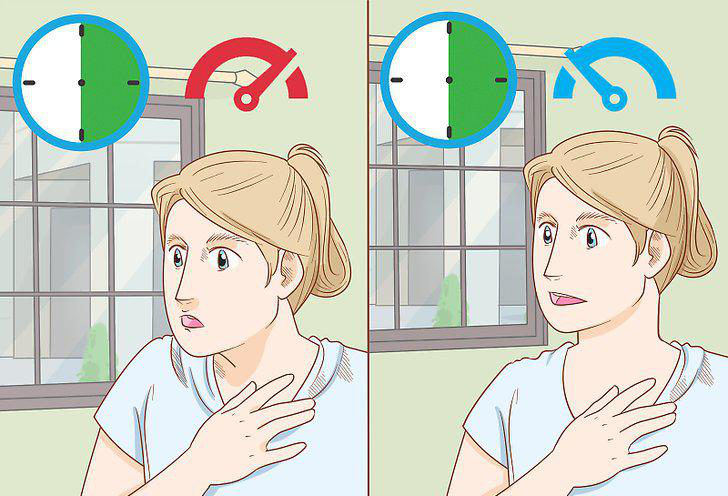

In [134]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(img_name_path))
image = img_name_path[rid] #'./img.jpg' #
real_caption = captions[rid]
print ('Real Caption:', real_caption)

for t in [0.5,0.7,0.9,1,1.2,1.5]:
    res, a = evaluate_temp(image, t, MAX_LENGTH, argmax =1)
    print(f"{t}, {''.join(res).replace('▁',' ')}, score {a}")
Image.open(image)

In [89]:
mask

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True,  True])>